### 准确率

分类正确的样本占总样本的比例：

$$\frac {N_{correct}} {N_{total}}$$

- 问题

当样本分布不均时，指标由占比大的类别决定。

相对应的也有错误率：分类错误的样本占总样本的比例。

写成积分的形式：

$$
error(f ; \mathcal{D})=\int_{\boldsymbol{x} \sim \mathcal{D}} \mathbb{I}(f(\boldsymbol{x}) \neq y) p(\boldsymbol{x}) \mathrm{d} \boldsymbol{x}
$$

$$
acc(f; \mathcal{D}) = 1 - error(f ; \mathcal{D})
$$

In [21]:
from sklearn.metrics import accuracy_score

import numpy as np
import numbers

from scipy.sparse import csr_matrix
from collections.abc import Sequence
from itertools import chain

from scipy.sparse import issparse
from scipy.sparse.base import spmatrix

In [3]:
y_pred = [0, 2, 1, 3]
y_true = [0, 1, 2, 3]
accuracy_score(y_true, y_pred)

0.5

#### 核心

其本质就是看分类器分对多少个，考察的是所有的类别。

很自然地，我们就能得出这个指标受最多类别的影响最大。

#### Sklearn 源代码

源代码比较复杂，考虑到了各种可能的边界和功能，主要有以下步骤：

- 检查类型
- 检查长度
- 统计非零
- 计算结果

In [30]:
def accuracy_score(y_true, y_pred, normalize=True, sample_weight=None):
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
    check_consistent_length(y_true, y_pred, sample_weight)
    if y_type.startswith('multilabel'):
        differing_labels = count_nonzero(y_true - y_pred, axis=1)
        score = differing_labels == 0
    else:
        score = y_true == y_pred

    return _weighted_sum(score, sample_weight, normalize)

In [13]:
def _check_targets(y_true, y_pred):
    check_consistent_length(y_true, y_pred)
    type_true = type_of_target(y_true)
    type_pred = type_of_target(y_pred)
    
    # set
    y_type = {type_true, type_pred}
    if y_type == {"binary", "multiclass"}:
        y_type = {"multiclass"}

    if len(y_type) > 1:
        raise ValueError("Classification metrics can't handle a mix of {0} "
                         "and {1} targets".format(type_true, type_pred))

    # We can't have more than one value on y_type => The set is no more needed
    y_type = y_type.pop()

    # No metrics support "multiclass-multioutput" format
    if (y_type not in ["binary", "multiclass", "multilabel-indicator"]):
        raise ValueError("{0} is not supported".format(y_type))

    if y_type in ["binary", "multiclass"]:
        y_true = column_or_1d(y_true)
        y_pred = column_or_1d(y_pred)
        if y_type == "binary":
            unique_values = np.union1d(y_true, y_pred)
            if len(unique_values) > 2:
                y_type = "multiclass"

    if y_type.startswith('multilabel'):
        y_true = csr_matrix(y_true)
        y_pred = csr_matrix(y_pred)
        y_type = 'multilabel-indicator'

    return y_type, y_true, y_pred

In [14]:
def check_consistent_length(*arrays):
    """Check that all arrays have consistent first dimensions.
    Checks whether all objects in arrays have the same shape or length."""
    lengths = [_num_samples(X) for X in arrays if X is not None]
    uniques = np.unique(lengths)
    if len(uniques) > 1:
        raise ValueError("Found input variables with inconsistent numbers of"
                         " samples: %r" % [int(l) for l in lengths])

In [15]:
def _num_samples(x):
    """Return number of samples in array-like x."""
    message = 'Expected sequence or array-like, got %s' % type(x)
    if hasattr(x, 'fit') and callable(x.fit):
        # Don't get num_samples from an ensembles length!
        raise TypeError(message)

    if not hasattr(x, '__len__') and not hasattr(x, 'shape'):
        if hasattr(x, '__array__'):
            x = np.asarray(x)
        else:
            raise TypeError(message)

    if hasattr(x, 'shape') and x.shape is not None:
        if len(x.shape) == 0:
            raise TypeError("Singleton array %r cannot be considered"
                            " a valid collection." % x)
        # Check that shape is returning an integer or default to len
        # Dask dataframes may not return numeric shape[0] value
        if isinstance(x.shape[0], numbers.Integral):
            return x.shape[0]

    try:
        return len(x)
    except TypeError:
        raise TypeError(message)

In [16]:
def type_of_target(y):
    """Determine the type of data indicated by the target.
    Note that this type is the most specific type that can be inferred.
    For example:
        * ``binary`` is more specific but compatible with ``multiclass``.
        * ``multiclass`` of integers is more specific but compatible with
          ``continuous``.
        * ``multilabel-indicator`` is more specific but compatible with
          ``multiclass-multioutput``.
    Parameters
    ----------
    y : array-like
    Returns
    -------
    target_type : string
        One of:
        * 'continuous': `y` is an array-like of floats that are not all
          integers, and is 1d or a column vector.
        * 'continuous-multioutput': `y` is a 2d array of floats that are
          not all integers, and both dimensions are of size > 1.
        * 'binary': `y` contains <= 2 discrete values and is 1d or a column
          vector.
        * 'multiclass': `y` contains more than two discrete values, is not a
          sequence of sequences, and is 1d or a column vector.
        * 'multiclass-multioutput': `y` is a 2d array that contains more
          than two discrete values, is not a sequence of sequences, and both
          dimensions are of size > 1.
        * 'multilabel-indicator': `y` is a label indicator matrix, an array
          of two dimensions with at least two columns, and at most 2 unique
          values.
        * 'unknown': `y` is array-like but none of the above, such as a 3d
          array, sequence of sequences, or an array of non-sequence objects.
    Examples
    --------
    >>> import numpy as np
    >>> type_of_target([0.1, 0.6])
    'continuous'
    >>> type_of_target([1, -1, -1, 1])
    'binary'
    >>> type_of_target(['a', 'b', 'a'])
    'binary'
    >>> type_of_target([1.0, 2.0])
    'binary'
    >>> type_of_target([1, 0, 2])
    'multiclass'
    >>> type_of_target([1.0, 0.0, 3.0])
    'multiclass'
    >>> type_of_target(['a', 'b', 'c'])
    'multiclass'
    >>> type_of_target(np.array([[1, 2], [3, 1]]))
    'multiclass-multioutput'
    >>> type_of_target([[1, 2]])
    'multilabel-indicator'
    >>> type_of_target(np.array([[1.5, 2.0], [3.0, 1.6]]))
    'continuous-multioutput'
    >>> type_of_target(np.array([[0, 1], [1, 1]]))
    'multilabel-indicator'
    """
    valid = ((isinstance(y, (Sequence, spmatrix)) or hasattr(y, '__array__'))
             and not isinstance(y, str))

    if not valid:
        raise ValueError('Expected array-like (array or non-string sequence), '
                         'got %r' % y)

    sparse_pandas = (y.__class__.__name__ in ['SparseSeries', 'SparseArray'])
    if sparse_pandas:
        raise ValueError("y cannot be class 'SparseSeries' or 'SparseArray'")

    if is_multilabel(y):
        return 'multilabel-indicator'

    try:
        y = np.asarray(y)
    except ValueError:
        # Known to fail in numpy 1.3 for array of arrays
        return 'unknown'

    # The old sequence of sequences format
    try:
        if (not hasattr(y[0], '__array__') and isinstance(y[0], Sequence)
                and not isinstance(y[0], str)):
            raise ValueError('You appear to be using a legacy multi-label data'
                             ' representation. Sequence of sequences are no'
                             ' longer supported; use a binary array or sparse'
                             ' matrix instead - the MultiLabelBinarizer'
                             ' transformer can convert to this format.')
    except IndexError:
        pass

    # Invalid inputs
    if y.ndim > 2 or (y.dtype == object and len(y) and
                      not isinstance(y.flat[0], str)):
        return 'unknown'  # [[[1, 2]]] or [obj_1] and not ["label_1"]

    if y.ndim == 2 and y.shape[1] == 0:
        return 'unknown'  # [[]]

    if y.ndim == 2 and y.shape[1] > 1:
        suffix = "-multioutput"  # [[1, 2], [1, 2]]
    else:
        suffix = ""  # [1, 2, 3] or [[1], [2], [3]]

    # check float and contains non-integer float values
    if y.dtype.kind == 'f' and np.any(y != y.astype(int)):
        # [.1, .2, 3] or [[.1, .2, 3]] or [[1., .2]] and not [1., 2., 3.]
        _assert_all_finite(y)
        return 'continuous' + suffix

    if (len(np.unique(y)) > 2) or (y.ndim >= 2 and len(y[0]) > 1):
        return 'multiclass' + suffix  # [1, 2, 3] or [[1., 2., 3]] or [[1, 2]]
    else:
        return 'binary'  # [1, 2] or [["a"], ["b"]]

In [24]:
def is_multilabel(y):
    """ Check if ``y`` is in a multilabel format.
    Parameters
    ----------
    y : numpy array of shape [n_samples]
        Target values.
    Returns
    -------
    out : bool,
        Return ``True``, if ``y`` is in a multilabel format, else ```False``.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.utils.multiclass import is_multilabel
    >>> is_multilabel([0, 1, 0, 1])
    False
    >>> is_multilabel([[1], [0, 2], []])
    False
    >>> is_multilabel(np.array([[1, 0], [0, 0]]))
    True
    >>> is_multilabel(np.array([[1], [0], [0]]))
    False
    >>> is_multilabel(np.array([[1, 0, 0]]))
    True
    """
    if hasattr(y, '__array__') or isinstance(y, Sequence):
        y = np.asarray(y)
    if not (hasattr(y, "shape") and y.ndim == 2 and y.shape[1] > 1):
        return False

    if issparse(y):
        if isinstance(y, (dok_matrix, lil_matrix)):
            y = y.tocsr()
        return (len(y.data) == 0 or np.unique(y.data).size == 1 and
                (y.dtype.kind in 'biu' or  # bool, int, uint
                 _is_integral_float(np.unique(y.data))))
    else:
        labels = np.unique(y)

        return len(labels) < 3 and (y.dtype.kind in 'biu' or  # bool, int, uint
                                    _is_integral_float(labels))

In [17]:
def column_or_1d(y, warn=False):
    """ Ravel column or 1d numpy array, else raises an error
    Parameters
    ----------
    y : array-like
    warn : boolean, default False
       To control display of warnings.
    Returns
    -------
    y : array
    """
    y = np.asarray(y)
    shape = np.shape(y)
    if len(shape) == 1:
        return np.ravel(y)
    if len(shape) == 2 and shape[1] == 1:
        if warn:
            warnings.warn("A column-vector y was passed when a 1d array was"
                          " expected. Please change the shape of y to "
                          "(n_samples, ), for example using ravel().",
                          DataConversionWarning, stacklevel=2)
        return np.ravel(y)

    raise ValueError("bad input shape {0}".format(shape))

In [18]:
def count_nonzero(X, axis=None, sample_weight=None):
    """A variant of X.getnnz() with extension to weighting on axis 0
    Useful in efficiently calculating multilabel metrics.
    Parameters
    ----------
    X : CSR sparse matrix of shape (n_samples, n_labels)
        Input data.
    axis : None, 0 or 1
        The axis on which the data is aggregated.
    sample_weight : array-like of shape (n_samples,), default=None
        Weight for each row of X.
    """
    if axis == -1:
        axis = 1
    elif axis == -2:
        axis = 0
    elif X.format != 'csr':
        raise TypeError('Expected CSR sparse format, got {0}'.format(X.format))

    # We rely here on the fact that np.diff(Y.indptr) for a CSR
    # will return the number of nonzero entries in each row.
    # A bincount over Y.indices will return the number of nonzeros
    # in each column. See ``csr_matrix.getnnz`` in scipy >= 0.14.
    if axis is None:
        if sample_weight is None:
            return X.nnz
        else:
            return np.dot(np.diff(X.indptr), sample_weight)
    elif axis == 1:
        out = np.diff(X.indptr)
        if sample_weight is None:
            # astype here is for consistency with axis=0 dtype
            return out.astype('intp')
        return out * sample_weight
    elif axis == 0:
        if sample_weight is None:
            return np.bincount(X.indices, minlength=X.shape[1])
        else:
            weights = np.repeat(sample_weight, np.diff(X.indptr))
            return np.bincount(X.indices, minlength=X.shape[1],
                            weights=weights)
    else:
        raise ValueError('Unsupported axis: {0}'.format(axis))

In [26]:
def _weighted_sum(sample_score, sample_weight, normalize=False):
    if normalize:
        return np.average(sample_score, weights=sample_weight)
    elif sample_weight is not None:
        return np.dot(sample_score, sample_weight)
    else:
        return sample_score.sum()

### P-R 与 F1

P（precision）是精准率，也叫查准率；

R（recall）是召回率，也叫查全率。

要想理解二者的含义，最好先知道混淆矩阵：

真实情况 | 预测结果正例| 预测结果反例
----|----|----
正例 | TP（真正例）|FN（假反例）
反例 | FP（假正例）|TN（真反例）

$$P = \frac {TP}{TP+FP}$$

$$R = \frac {TP}{TP+FN}$$

以前老是记不住，后来也就不记了，用的时候把混淆矩阵拿出来一看就知道了。通俗点解释就是：精准率是模型判断是正例中有多少是真正的正例；召回率是模型判断是真正的正例与实际正例的比例。

PR 可以绘制 P-R 曲线图，纵坐标是 P 横坐标是 R，一般而言二者是互相对立的，也就是说高 P 一般对应低 R，反之亦然。

所以，这之间必然有一个平衡点，P-R 曲线的平衡点叫 BEP（Break-Even Point），平衡点越靠右上表示模型越好。

在实际中，更常用的是 F1 度量：

$$
F1 = \frac {2PR}{P+R}
$$

F1 有更一般的形式：

$$
F_{\beta}=\frac{\left(1+\beta^{2}\right) \times P \times R}{\left(\beta^{2} \times P\right)+R}
$$

详细可参考：[Naive Bayes and Sentiment Classification Note (SLP Ch04) | Yam](https://yam.gift/2019/05/05/SLP/2019-05-05-NaiveBayes-and-Sentiment-Classification/)

另外，多次评估时，有两种方式考察 PR：

- 先计算每个 PR，取平均后，再计算 F1：macro 方法
- 先计算混淆矩阵元素的平均，再计算 PR 和 F1：micro 方法

记忆的时候可以这么理解：micro 方法只要计算一次 PR，而 macro 方法需要计算多次 PR。

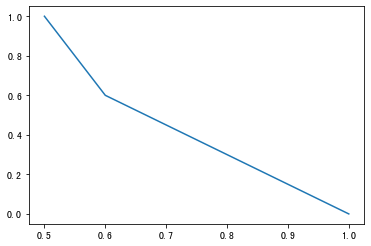

In [3]:
from sklearn.metrics import precision_recall_curve
# y_pred_prob = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5,
#                0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0]
# y_true = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0]
# y_true2 = [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0]
# y_pred = [1] * 10 + [0] * 10

import matplotlib.pyplot as plt
y_pred_prob = [0.9, 0.8, 0.7, 0.6, 0.55, 0.54, 0.53, 0.52, 0.51, 0.505,
               0.4, 0.39, 0.38, 0.37, 0.36, 0.35, 0.34, 0.33, 0.3, 0.1]
y_true = [1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
y_pred = [1] * 10 + [0] * 10

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
plt.plot(precision, recall);

In [8]:
from typing import List, Tuple

In [9]:
def get_confusion_matrix(
    y_pred: List[int], 
    y_true: List[int]
    ) -> Tuple[int, int, int, int]:
    
    length = len(y_pred)
    assert length == len(y_true)
    tp, fp, fn, tn = 0, 0, 0, 0
    for i in range(length):
        if y_pred[i] == y_true[i] and y_pred[i] == 1:
            tp += 1
        elif y_pred[i] == y_true[i] and y_pred[i] == 0:
            tn += 1
        elif y_pred[i] == 1 and y_true[i] == 0:
            fp += 1
        elif y_pred[i] == 0 and y_true[i] == 1:
            fn += 1
    return (tp, fp, tn, fn)

In [10]:
tp, fp, tn, fn = get_confusion_matrix(y_pred, y_true)

In [11]:
def calc_p(tp: int, fp: int) -> float:
    return tp / (tp + fp)
def calc_r(tp: int, fn: int) -> float:
    return tp / (tp + fn)

In [12]:
calc_p(tp, fp), calc_r(tp, fn)

(0.6, 0.6)

In [13]:
def get_pr_pairs(y_pred_prob: List[float], y_true: List[int]) -> Tuple[List[int], List[int]]:
    ps = [1]
    rs = [0]
    for prob1 in y_pred_prob:
        y_pred_i = []
        for prob2 in y_pred_prob:
            if prob2 < prob1:
                y_pred_i.append(0)
            else:
                y_pred_i.append(1)
        tp, fp, tn, fn = get_confusion_matrix(y_pred_i, y_true)
        p = calc_p(tp, fp)
        r = calc_r(tp, fn)
        ps.append(p)
        rs.append(r)
    ps.append(0)
    rs.append(1)
    return ps, rs

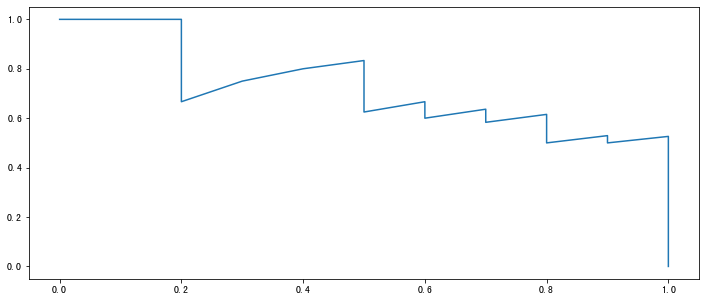

In [14]:
ps, rs = get_pr_pairs(y_pred_prob, y_true)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

ax.plot(rs, ps);

In [15]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [16]:
confusion_matrix(y_true, y_pred)

array([[6, 4],
       [4, 6]])

In [17]:
precision_score(y_true, y_pred), recall_score(y_true, y_pred)

(0.6, 0.6)

#### 核心

P-R 和 F1 本质上是基于正例的，准确来说是模型预测的真正例。

P 是精准率，也就是预测出来的所有正例中，是真正例的比例；

R 是召回率，也就是所有实际真正正例中，预测为真正例的比例。

前者关注的是预测的准确性，后者关注的是有多少结果被预测出来了。

这样的评估方式比起 Accuracy 就进步太多了，尤其对于不同类别分布不均匀的情况。此时精准率可能很高，但召回率却很低。

#### Sklearn 源代码

源代码主要有以下步骤：

- 检查计算中有没有 0 值，比如没有 positive 的 Recall
- 检查 label
- 计算混淆矩阵
- 计算 p r


我已经被下面这波操作震到了，看来对 “工程” 理解还是很浅薄啊，这才是需要学习的代码。先过完一遍回头来补。

In [13]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from inspect import signature, isclass, Parameter
import warnings

In [14]:
y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]

In [79]:
precision_recall_fscore_support(y_true, y_pred, average='micro')

(0.6666666666666666, 0.6666666666666666, 0.6666666666666666, None)

In [76]:
class UndefinedMetricWarning(UserWarning):
    """Warning used when the metric is invalid
    .. versionchanged:: 0.18
       Moved from sklearn.base.
    """

In [33]:
# precision_score, recall_score, f1_score 都是基于本函数
def precision_recall_fscore_support(y_true, y_pred, beta=1.0, labels=None,
                                    pos_label=1, average=None,
                                    warn_for=('precision', 'recall',
                                              'f-score'),
                                    sample_weight=None,
                                    zero_division="warn"):
    """Compute precision, recall, F-measure and support for each class
    The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
    true positives and ``fp`` the number of false positives. The precision is
    intuitively the ability of the classifier not to label as positive a sample
    that is negative.
    The recall is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of
    true positives and ``fn`` the number of false negatives. The recall is
    intuitively the ability of the classifier to find all the positive samples.
    The F-beta score can be interpreted as a weighted harmonic mean of
    the precision and recall, where an F-beta score reaches its best
    value at 1 and worst score at 0.
    The F-beta score weights recall more than precision by a factor of
    ``beta``. ``beta == 1.0`` means recall and precision are equally important.
    The support is the number of occurrences of each class in ``y_true``.
    If ``pos_label is None`` and in binary classification, this function
    returns the average precision, recall and F-measure if ``average``
    is one of ``'micro'``, ``'macro'``, ``'weighted'`` or ``'samples'``.
    Read more in the :ref:`User Guide <precision_recall_f_measure_metrics>`.
    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.
    y_pred : 1d array-like, or label indicator array / sparse matrix
        Estimated targets as returned by a classifier.
    beta : float, 1.0 by default
        The strength of recall versus precision in the F-score.
    labels : list, optional
        The set of labels to include when ``average != 'binary'``, and their
        order if ``average is None``. Labels present in the data can be
        excluded, for example to calculate a multiclass average ignoring a
        majority negative class, while labels not present in the data will
        result in 0 components in a macro average. For multilabel targets,
        labels are column indices. By default, all labels in ``y_true`` and
        ``y_pred`` are used in sorted order.
    pos_label : str or int, 1 by default
        The class to report if ``average='binary'`` and the data is binary.
        If the data are multiclass or multilabel, this will be ignored;
        setting ``labels=[pos_label]`` and ``average != 'binary'`` will report
        scores for that label only.
    average : string, [None (default), 'binary', 'micro', 'macro', 'samples', \
                       'weighted']
        If ``None``, the scores for each class are returned. Otherwise, this
        determines the type of averaging performed on the data:
        ``'binary'``:
            Only report results for the class specified by ``pos_label``.
            This is applicable only if targets (``y_{true,pred}``) are binary.
        ``'micro'``:
            Calculate metrics globally by counting the total true positives,
            false negatives and false positives.
        ``'macro'``:
            Calculate metrics for each label, and find their unweighted
            mean.  This does not take label imbalance into account.
        ``'weighted'``:
            Calculate metrics for each label, and find their average weighted
            by support (the number of true instances for each label). This
            alters 'macro' to account for label imbalance; it can result in an
            F-score that is not between precision and recall.
        ``'samples'``:
            Calculate metrics for each instance, and find their average (only
            meaningful for multilabel classification where this differs from
            :func:`accuracy_score`).
    warn_for : tuple or set, for internal use
        This determines which warnings will be made in the case that this
        function is being used to return only one of its metrics.
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    zero_division : "warn", 0 or 1, default="warn"
        Sets the value to return when there is a zero division:
           - recall: when there are no positive labels
           - precision: when there are no positive predictions
           - f-score: both
        If set to "warn", this acts as 0, but warnings are also raised.
    Returns
    -------
    precision : float (if average is not None) or array of float, shape =\
        [n_unique_labels]
    recall : float (if average is not None) or array of float, , shape =\
        [n_unique_labels]
    fbeta_score : float (if average is not None) or array of float, shape =\
        [n_unique_labels]
    support : int (if average is not None) or array of int, shape =\
        [n_unique_labels]
        The number of occurrences of each label in ``y_true``.
    References
    ----------
    .. [1] `Wikipedia entry for the Precision and recall
           <https://en.wikipedia.org/wiki/Precision_and_recall>`_
    .. [2] `Wikipedia entry for the F1-score
           <https://en.wikipedia.org/wiki/F1_score>`_
    .. [3] `Discriminative Methods for Multi-labeled Classification Advances
           in Knowledge Discovery and Data Mining (2004), pp. 22-30 by Shantanu
           Godbole, Sunita Sarawagi
           <http://www.godbole.net/shantanu/pubs/multilabelsvm-pakdd04.pdf>`_
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.metrics import precision_recall_fscore_support
    >>> y_true = np.array(['cat', 'dog', 'pig', 'cat', 'dog', 'pig'])
    >>> y_pred = np.array(['cat', 'pig', 'dog', 'cat', 'cat', 'dog'])
    >>> precision_recall_fscore_support(y_true, y_pred, average='macro')
    (0.22..., 0.33..., 0.26..., None)
    >>> precision_recall_fscore_support(y_true, y_pred, average='micro')
    (0.33..., 0.33..., 0.33..., None)
    >>> precision_recall_fscore_support(y_true, y_pred, average='weighted')
    (0.22..., 0.33..., 0.26..., None)
    It is possible to compute per-label precisions, recalls, F1-scores and
    supports instead of averaging:
    >>> precision_recall_fscore_support(y_true, y_pred, average=None,
    ... labels=['pig', 'dog', 'cat'])
    (array([0.        , 0.        , 0.66...]),
     array([0., 0., 1.]), array([0. , 0. , 0.8]),
     array([2, 2, 2]))
    Notes
    -----
    When ``true positive + false positive == 0``, precision is undefined;
    When ``true positive + false negative == 0``, recall is undefined.
    In such cases, by default the metric will be set to 0, as will f-score,
    and ``UndefinedMetricWarning`` will be raised. This behavior can be
    modified with ``zero_division``.
    """
    _check_zero_division(zero_division)
    if beta < 0:
        raise ValueError("beta should be >=0 in the F-beta score")
    labels = _check_set_wise_labels(y_true, y_pred, average, labels,
                                    pos_label)

    # Calculate tp_sum, pred_sum, true_sum ###
    samplewise = average == 'samples'
    MCM = multilabel_confusion_matrix(y_true, y_pred,
                                      sample_weight=sample_weight,
                                      labels=labels, samplewise=samplewise)
    tp_sum = MCM[:, 1, 1]
    pred_sum = tp_sum + MCM[:, 0, 1]
    true_sum = tp_sum + MCM[:, 1, 0]

    if average == 'micro':
        tp_sum = np.array([tp_sum.sum()])
        pred_sum = np.array([pred_sum.sum()])
        true_sum = np.array([true_sum.sum()])

    # Finally, we have all our sufficient statistics. Divide! #
    beta2 = beta ** 2

    # Divide, and on zero-division, set scores and/or warn according to
    # zero_division:
    precision = _prf_divide(tp_sum, pred_sum, 'precision',
                            'predicted', average, warn_for, zero_division)
    recall = _prf_divide(tp_sum, true_sum, 'recall',
                         'true', average, warn_for, zero_division)

    # warn for f-score only if zero_division is warn, it is in warn_for
    # and BOTH prec and rec are ill-defined
    if zero_division == "warn" and ("f-score",) == warn_for:
        if (pred_sum[true_sum == 0] == 0).any():
            _warn_prf(
                average, "true nor predicted", 'F-score is', len(true_sum)
            )

    # if tp == 0 F will be 1 only if all predictions are zero, all labels are
    # zero, and zero_division=1. In all other case, 0
    if np.isposinf(beta):
        f_score = recall
    else:
        denom = beta2 * precision + recall

        denom[denom == 0.] = 1  # avoid division by 0
        f_score = (1 + beta2) * precision * recall / denom

    # Average the results
    if average == 'weighted':
        weights = true_sum
        if weights.sum() == 0:
            zero_division_value = 0.0 if zero_division in ["warn", 0] else 1.0
            # precision is zero_division if there are no positive predictions
            # recall is zero_division if there are no positive labels
            # fscore is zero_division if all labels AND predictions are
            # negative
            return (zero_division_value if pred_sum.sum() == 0 else 0,
                    zero_division_value,
                    zero_division_value if pred_sum.sum() == 0 else 0,
                    None)

    elif average == 'samples':
        weights = sample_weight
    else:
        weights = None

    if average is not None:
        assert average != 'binary' or len(precision) == 1
        precision = np.average(precision, weights=weights)
        recall = np.average(recall, weights=weights)
        f_score = np.average(f_score, weights=weights)
        true_sum = None  # return no support

    return precision, recall, f_score, true_sum

In [72]:
def _warn_prf(average, modifier, msg_start, result_size):
    axis0, axis1 = 'sample', 'label'
    if average == 'samples':
        axis0, axis1 = axis1, axis0
    msg = ('{0} ill-defined and being set to 0.0 {{0}} '
           'no {1} {2}s. Use `zero_division` parameter to control'
           ' this behavior.'.format(msg_start, modifier, axis0))
    if result_size == 1:
        msg = msg.format('due to')
    else:
        msg = msg.format('in {0}s with'.format(axis1))
    warnings.warn(msg, UndefinedMetricWarning, stacklevel=2)

In [70]:
def _prf_divide(numerator, denominator, metric,
                modifier, average, warn_for, zero_division="warn"):
    """Performs division and handles divide-by-zero.
    On zero-division, sets the corresponding result elements equal to
    0 or 1 (according to ``zero_division``). Plus, if
    ``zero_division != "warn"`` raises a warning.
    The metric, modifier and average arguments are used only for determining
    an appropriate warning.
    """
    mask = denominator == 0.0
    denominator = denominator.copy()
    denominator[mask] = 1  # avoid infs/nans
    result = numerator / denominator

    if not np.any(mask):
        return result

    # if ``zero_division=1``, set those with denominator == 0 equal to 1
    result[mask] = 0.0 if zero_division in ["warn", 0] else 1.0

    # the user will be removing warnings if zero_division is set to something
    # different than its default value. If we are computing only f-score
    # the warning will be raised only if precision and recall are ill-defined
    if zero_division != "warn" or metric not in warn_for:
        return result

    # build appropriate warning
    # E.g. "Precision and F-score are ill-defined and being set to 0.0 in
    # labels with no predicted samples. Use ``zero_division`` parameter to
    # control this behavior."

    if metric in warn_for and 'f-score' in warn_for:
        msg_start = '{0} and F-score are'.format(metric.title())
    elif metric in warn_for:
        msg_start = '{0} is'.format(metric.title())
    elif 'f-score' in warn_for:
        msg_start = 'F-score is'
    else:
        return result

    _warn_prf(average, modifier, msg_start, len(result))

    return result

In [34]:
def _check_zero_division(zero_division):
    if isinstance(zero_division, str) and zero_division == "warn":
        return
    elif isinstance(zero_division, (int, float)) and zero_division in [0, 1]:
        return
    raise ValueError('Got zero_division={0}.'
                     ' Must be one of ["warn", 0, 1]'.format(zero_division))

In [35]:
def _check_set_wise_labels(y_true, y_pred, average, labels, pos_label):
    """Validation associated with set-wise metrics
    Returns identified labels
    """
    average_options = (None, 'micro', 'macro', 'weighted', 'samples')
    if average not in average_options and average != 'binary':
        raise ValueError('average has to be one of ' +
                         str(average_options))

    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
    present_labels = unique_labels(y_true, y_pred)
    if average == 'binary':
        if y_type == 'binary':
            if pos_label not in present_labels:
                if len(present_labels) >= 2:
                    raise ValueError("pos_label=%r is not a valid label: "
                                     "%r" % (pos_label, present_labels))
            labels = [pos_label]
        else:
            average_options = list(average_options)
            if y_type == 'multiclass':
                average_options.remove('samples')
            raise ValueError("Target is %s but average='binary'. Please "
                             "choose another average setting, one of %r."
                             % (y_type, average_options))
    elif pos_label not in (None, 1):
        warnings.warn("Note that pos_label (set to %r) is ignored when "
                      "average != 'binary' (got %r). You may use "
                      "labels=[pos_label] to specify a single positive class."
                      % (pos_label, average), UserWarning)
    return labels

In [36]:
def unique_labels(*ys):
    """Extract an ordered array of unique labels
    We don't allow:
        - mix of multilabel and multiclass (single label) targets
        - mix of label indicator matrix and anything else,
          because there are no explicit labels)
        - mix of label indicator matrices of different sizes
        - mix of string and integer labels
    At the moment, we also don't allow "multiclass-multioutput" input type.
    Parameters
    ----------
    *ys : array-likes
    Returns
    -------
    out : numpy array of shape [n_unique_labels]
        An ordered array of unique labels.
    Examples
    --------
    >>> from sklearn.utils.multiclass import unique_labels
    >>> unique_labels([3, 5, 5, 5, 7, 7])
    array([3, 5, 7])
    >>> unique_labels([1, 2, 3, 4], [2, 2, 3, 4])
    array([1, 2, 3, 4])
    >>> unique_labels([1, 2, 10], [5, 11])
    array([ 1,  2,  5, 10, 11])
    """
    if not ys:
        raise ValueError('No argument has been passed.')
    # Check that we don't mix label format

    ys_types = set(type_of_target(x) for x in ys)
    if ys_types == {"binary", "multiclass"}:
        ys_types = {"multiclass"}

    if len(ys_types) > 1:
        raise ValueError("Mix type of y not allowed, got types %s" % ys_types)

    label_type = ys_types.pop()

    # Check consistency for the indicator format
    if (label_type == "multilabel-indicator" and
            len(set(check_array(y, ['csr', 'csc', 'coo']).shape[1]
                    for y in ys)) > 1):
        raise ValueError("Multi-label binary indicator input with "
                         "different numbers of labels")

    # Get the unique set of labels
    _unique_labels = _FN_UNIQUE_LABELS.get(label_type, None)
    if not _unique_labels:
        raise ValueError("Unknown label type: %s" % repr(ys))

    ys_labels = set(chain.from_iterable(_unique_labels(y) for y in ys))

    # Check that we don't mix string type with number type
    if (len(set(isinstance(label, str) for label in ys_labels)) > 1):
        raise ValueError("Mix of label input types (string and number)")

    return np.array(sorted(ys_labels))

In [37]:
def _unique_multiclass(y):
    if hasattr(y, '__array__'):
        return np.unique(np.asarray(y))
    else:
        return set(y)


def _unique_indicator(y):
    return np.arange(check_array(y, ['csr', 'csc', 'coo']).shape[1])


_FN_UNIQUE_LABELS = {
    'binary': _unique_multiclass,
    'multiclass': _unique_multiclass,
    'multilabel-indicator': _unique_indicator,
}

In [42]:
def multilabel_confusion_matrix(y_true, y_pred, sample_weight=None,
                                labels=None, samplewise=False):
    """Compute a confusion matrix for each class or sample
    .. versionadded:: 0.21
    Compute class-wise (default) or sample-wise (samplewise=True) multilabel
    confusion matrix to evaluate the accuracy of a classification, and output
    confusion matrices for each class or sample.
    In multilabel confusion matrix :math:`MCM`, the count of true negatives
    is :math:`MCM_{:,0,0}`, false negatives is :math:`MCM_{:,1,0}`,
    true positives is :math:`MCM_{:,1,1}` and false positives is
    :math:`MCM_{:,0,1}`.
    Multiclass data will be treated as if binarized under a one-vs-rest
    transformation. Returned confusion matrices will be in the order of
    sorted unique labels in the union of (y_true, y_pred).
    Read more in the :ref:`User Guide <multilabel_confusion_matrix>`.
    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        of shape (n_samples, n_outputs) or (n_samples,)
        Ground truth (correct) target values.
    y_pred : 1d array-like, or label indicator array / sparse matrix
        of shape (n_samples, n_outputs) or (n_samples,)
        Estimated targets as returned by a classifier
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights
    labels : array-like
        A list of classes or column indices to select some (or to force
        inclusion of classes absent from the data)
    samplewise : bool, default=False
        In the multilabel case, this calculates a confusion matrix per sample
    Returns
    -------
    multi_confusion : array, shape (n_outputs, 2, 2)
        A 2x2 confusion matrix corresponding to each output in the input.
        When calculating class-wise multi_confusion (default), then
        n_outputs = n_labels; when calculating sample-wise multi_confusion
        (samplewise=True), n_outputs = n_samples. If ``labels`` is defined,
        the results will be returned in the order specified in ``labels``,
        otherwise the results will be returned in sorted order by default.
    See also
    --------
    confusion_matrix
    Notes
    -----
    The multilabel_confusion_matrix calculates class-wise or sample-wise
    multilabel confusion matrices, and in multiclass tasks, labels are
    binarized under a one-vs-rest way; while confusion_matrix calculates
    one confusion matrix for confusion between every two classes.
    Examples
    --------
    Multilabel-indicator case:
    >>> import numpy as np
    >>> from sklearn.metrics import multilabel_confusion_matrix
    >>> y_true = np.array([[1, 0, 1],
    ...                    [0, 1, 0]])
    >>> y_pred = np.array([[1, 0, 0],
    ...                    [0, 1, 1]])
    >>> multilabel_confusion_matrix(y_true, y_pred)
    array([[[1, 0],
            [0, 1]],
    <BLANKLINE>
           [[1, 0],
            [0, 1]],
    <BLANKLINE>
           [[0, 1],
            [1, 0]]])
    Multiclass case:
    >>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
    >>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
    >>> multilabel_confusion_matrix(y_true, y_pred,
    ...                             labels=["ant", "bird", "cat"])
    array([[[3, 1],
            [0, 2]],
    <BLANKLINE>
           [[5, 0],
            [1, 0]],
    <BLANKLINE>
           [[2, 1],
            [1, 2]]])
    """
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
    if sample_weight is not None:
        sample_weight = column_or_1d(sample_weight)
    check_consistent_length(y_true, y_pred, sample_weight)

    if y_type not in ("binary", "multiclass", "multilabel-indicator"):
        raise ValueError("%s is not supported" % y_type)

    present_labels = unique_labels(y_true, y_pred)
    if labels is None:
        labels = present_labels
        n_labels = None
    else:
        n_labels = len(labels)
        labels = np.hstack([labels, np.setdiff1d(present_labels, labels,
                                                 assume_unique=True)])

    if y_true.ndim == 1:
        if samplewise:
            raise ValueError("Samplewise metrics are not available outside of "
                             "multilabel classification.")

        le = LabelEncoder()
        le.fit(labels)
        y_true = le.transform(y_true)
        y_pred = le.transform(y_pred)
        sorted_labels = le.classes_

        # labels are now from 0 to len(labels) - 1 -> use bincount
        tp = y_true == y_pred
        tp_bins = y_true[tp]
        if sample_weight is not None:
            tp_bins_weights = np.asarray(sample_weight)[tp]
        else:
            tp_bins_weights = None

        if len(tp_bins):
            tp_sum = np.bincount(tp_bins, weights=tp_bins_weights,
                                 minlength=len(labels))
        else:
            # Pathological case
            true_sum = pred_sum = tp_sum = np.zeros(len(labels))
        if len(y_pred):
            pred_sum = np.bincount(y_pred, weights=sample_weight,
                                   minlength=len(labels))
        if len(y_true):
            true_sum = np.bincount(y_true, weights=sample_weight,
                                   minlength=len(labels))

        # Retain only selected labels
        indices = np.searchsorted(sorted_labels, labels[:n_labels])
        tp_sum = tp_sum[indices]
        true_sum = true_sum[indices]
        pred_sum = pred_sum[indices]

    else:
        sum_axis = 1 if samplewise else 0

        # All labels are index integers for multilabel.
        # Select labels:
        if not np.array_equal(labels, present_labels):
            if np.max(labels) > np.max(present_labels):
                raise ValueError('All labels must be in [0, n labels) for '
                                 'multilabel targets. '
                                 'Got %d > %d' %
                                 (np.max(labels), np.max(present_labels)))
            if np.min(labels) < 0:
                raise ValueError('All labels must be in [0, n labels) for '
                                 'multilabel targets. '
                                 'Got %d < 0' % np.min(labels))

        if n_labels is not None:
            y_true = y_true[:, labels[:n_labels]]
            y_pred = y_pred[:, labels[:n_labels]]

        # calculate weighted counts
        true_and_pred = y_true.multiply(y_pred)
        tp_sum = count_nonzero(true_and_pred, axis=sum_axis,
                               sample_weight=sample_weight)
        pred_sum = count_nonzero(y_pred, axis=sum_axis,
                                 sample_weight=sample_weight)
        true_sum = count_nonzero(y_true, axis=sum_axis,
                                 sample_weight=sample_weight)

    fp = pred_sum - tp_sum
    fn = true_sum - tp_sum
    tp = tp_sum

    if sample_weight is not None and samplewise:
        sample_weight = np.array(sample_weight)
        tp = np.array(tp)
        fp = np.array(fp)
        fn = np.array(fn)
        tn = sample_weight * y_true.shape[1] - tp - fp - fn
    elif sample_weight is not None:
        tn = sum(sample_weight) - tp - fp - fn
    elif samplewise:
        tn = y_true.shape[1] - tp - fp - fn
    else:
        tn = y_true.shape[0] - tp - fp - fn

    return np.array([tn, fp, fn, tp]).T.reshape(-1, 2, 2)

In [47]:
class TransformerMixin:
    """Mixin class for all transformers in scikit-learn."""

    def fit_transform(self, X, y=None, **fit_params):
        """
        Fit to data, then transform it.
        Fits transformer to X and y with optional parameters fit_params
        and returns a transformed version of X.
        Parameters
        ----------
        X : numpy array of shape [n_samples, n_features]
            Training set.
        y : numpy array of shape [n_samples]
            Target values.
        **fit_params : dict
            Additional fit parameters.
        Returns
        -------
        X_new : numpy array of shape [n_samples, n_features_new]
            Transformed array.
        """
        # non-optimized default implementation; override when a better
        # method is possible for a given clustering algorithm
        if y is None:
            # fit method of arity 1 (unsupervised transformation)
            return self.fit(X, **fit_params).transform(X)
        else:
            # fit method of arity 2 (supervised transformation)
            return self.fit(X, y, **fit_params).transform(X)

In [49]:
class BaseEstimator:
    """Base class for all estimators in scikit-learn
    Notes
    -----
    All estimators should specify all the parameters that can be set
    at the class level in their ``__init__`` as explicit keyword
    arguments (no ``*args`` or ``**kwargs``).
    """

    @classmethod
    def _get_param_names(cls):
        """Get parameter names for the estimator"""
        # fetch the constructor or the original constructor before
        # deprecation wrapping if any
        init = getattr(cls.__init__, 'deprecated_original', cls.__init__)
        if init is object.__init__:
            # No explicit constructor to introspect
            return []

        # introspect the constructor arguments to find the model parameters
        # to represent
        init_signature = inspect.signature(init)
        # Consider the constructor parameters excluding 'self'
        parameters = [p for p in init_signature.parameters.values()
                      if p.name != 'self' and p.kind != p.VAR_KEYWORD]
        for p in parameters:
            if p.kind == p.VAR_POSITIONAL:
                raise RuntimeError("scikit-learn estimators should always "
                                   "specify their parameters in the signature"
                                   " of their __init__ (no varargs)."
                                   " %s with constructor %s doesn't "
                                   " follow this convention."
                                   % (cls, init_signature))
        # Extract and sort argument names excluding 'self'
        return sorted([p.name for p in parameters])

    def get_params(self, deep=True):
        """
        Get parameters for this estimator.
        Parameters
        ----------
        deep : bool, default=True
            If True, will return the parameters for this estimator and
            contained subobjects that are estimators.
        Returns
        -------
        params : mapping of string to any
            Parameter names mapped to their values.
        """
        out = dict()
        for key in self._get_param_names():
            try:
                value = getattr(self, key)
            except AttributeError:
                warnings.warn('From version 0.24, get_params will raise an '
                              'AttributeError if a parameter cannot be '
                              'retrieved as an instance attribute. Previously '
                              'it would return None.',
                              FutureWarning)
                value = None
            if deep and hasattr(value, 'get_params'):
                deep_items = value.get_params().items()
                out.update((key + '__' + k, val) for k, val in deep_items)
            out[key] = value
        return out

    def set_params(self, **params):
        """
        Set the parameters of this estimator.
        The method works on simple estimators as well as on nested objects
        (such as pipelines). The latter have parameters of the form
        ``<component>__<parameter>`` so that it's possible to update each
        component of a nested object.
        Parameters
        ----------
        **params : dict
            Estimator parameters.
        Returns
        -------
        self : object
            Estimator instance.
        """
        if not params:
            # Simple optimization to gain speed (inspect is slow)
            return self
        valid_params = self.get_params(deep=True)

        nested_params = defaultdict(dict)  # grouped by prefix
        for key, value in params.items():
            key, delim, sub_key = key.partition('__')
            if key not in valid_params:
                raise ValueError('Invalid parameter %s for estimator %s. '
                                 'Check the list of available parameters '
                                 'with `estimator.get_params().keys()`.' %
                                 (key, self))

            if delim:
                nested_params[key][sub_key] = value
            else:
                setattr(self, key, value)
                valid_params[key] = value

        for key, sub_params in nested_params.items():
            valid_params[key].set_params(**sub_params)

        return self

    def __repr__(self, N_CHAR_MAX=700):
        # N_CHAR_MAX is the (approximate) maximum number of non-blank
        # characters to render. We pass it as an optional parameter to ease
        # the tests.

        from .utils._pprint import _EstimatorPrettyPrinter

        N_MAX_ELEMENTS_TO_SHOW = 30  # number of elements to show in sequences

        # use ellipsis for sequences with a lot of elements
        pp = _EstimatorPrettyPrinter(
            compact=True, indent=1, indent_at_name=True,
            n_max_elements_to_show=N_MAX_ELEMENTS_TO_SHOW)

        repr_ = pp.pformat(self)

        # Use bruteforce ellipsis when there are a lot of non-blank characters
        n_nonblank = len(''.join(repr_.split()))
        if n_nonblank > N_CHAR_MAX:
            lim = N_CHAR_MAX // 2  # apprx number of chars to keep on both ends
            regex = r'^(\s*\S){%d}' % lim
            # The regex '^(\s*\S){%d}' % n
            # matches from the start of the string until the nth non-blank
            # character:
            # - ^ matches the start of string
            # - (pattern){n} matches n repetitions of pattern
            # - \s*\S matches a non-blank char following zero or more blanks
            left_lim = re.match(regex, repr_).end()
            right_lim = re.match(regex, repr_[::-1]).end()

            if '\n' in repr_[left_lim:-right_lim]:
                # The left side and right side aren't on the same line.
                # To avoid weird cuts, e.g.:
                # categoric...ore',
                # we need to start the right side with an appropriate newline
                # character so that it renders properly as:
                # categoric...
                # handle_unknown='ignore',
                # so we add [^\n]*\n which matches until the next \n
                regex += r'[^\n]*\n'
                right_lim = re.match(regex, repr_[::-1]).end()

            ellipsis = '...'
            if left_lim + len(ellipsis) < len(repr_) - right_lim:
                # Only add ellipsis if it results in a shorter repr
                repr_ = repr_[:left_lim] + '...' + repr_[-right_lim:]

        return repr_

    def __getstate__(self):
        try:
            state = super().__getstate__()
        except AttributeError:
            state = self.__dict__.copy()

        if type(self).__module__.startswith('sklearn.'):
            return dict(state.items(), _sklearn_version=__version__)
        else:
            return state

    def __setstate__(self, state):
        if type(self).__module__.startswith('sklearn.'):
            pickle_version = state.pop("_sklearn_version", "pre-0.18")
            if pickle_version != __version__:
                warnings.warn(
                    "Trying to unpickle estimator {0} from version {1} when "
                    "using version {2}. This might lead to breaking code or "
                    "invalid results. Use at your own risk.".format(
                        self.__class__.__name__, pickle_version, __version__),
                    UserWarning)
        try:
            super().__setstate__(state)
        except AttributeError:
            self.__dict__.update(state)

    def _more_tags(self):
        return _DEFAULT_TAGS

    def _get_tags(self):
        collected_tags = {}
        for base_class in reversed(inspect.getmro(self.__class__)):
            if hasattr(base_class, '_more_tags'):
                # need the if because mixins might not have _more_tags
                # but might do redundant work in estimators
                # (i.e. calling more tags on BaseEstimator multiple times)
                more_tags = base_class._more_tags(self)
                collected_tags.update(more_tags)
        return collected_tags

In [50]:
class LabelEncoder(TransformerMixin, BaseEstimator):
    """Encode target labels with value between 0 and n_classes-1.
    This transformer should be used to encode target values, *i.e.* `y`, and
    not the input `X`.
    Read more in the :ref:`User Guide <preprocessing_targets>`.
    .. versionadded:: 0.12
    Attributes
    ----------
    classes_ : array of shape (n_class,)
        Holds the label for each class.
    Examples
    --------
    `LabelEncoder` can be used to normalize labels.
    >>> from sklearn import preprocessing
    >>> le = preprocessing.LabelEncoder()
    >>> le.fit([1, 2, 2, 6])
    LabelEncoder()
    >>> le.classes_
    array([1, 2, 6])
    >>> le.transform([1, 1, 2, 6])
    array([0, 0, 1, 2]...)
    >>> le.inverse_transform([0, 0, 1, 2])
    array([1, 1, 2, 6])
    It can also be used to transform non-numerical labels (as long as they are
    hashable and comparable) to numerical labels.
    >>> le = preprocessing.LabelEncoder()
    >>> le.fit(["paris", "paris", "tokyo", "amsterdam"])
    LabelEncoder()
    >>> list(le.classes_)
    ['amsterdam', 'paris', 'tokyo']
    >>> le.transform(["tokyo", "tokyo", "paris"])
    array([2, 2, 1]...)
    >>> list(le.inverse_transform([2, 2, 1]))
    ['tokyo', 'tokyo', 'paris']
    See also
    --------
    sklearn.preprocessing.OrdinalEncoder : Encode categorical features
        using an ordinal encoding scheme.
    sklearn.preprocessing.OneHotEncoder : Encode categorical features
        as a one-hot numeric array.
    """

    def fit(self, y):
        """Fit label encoder
        Parameters
        ----------
        y : array-like of shape (n_samples,)
            Target values.
        Returns
        -------
        self : returns an instance of self.
        """
        y = column_or_1d(y, warn=True)
        self.classes_ = _encode(y)
        return self

    def fit_transform(self, y):
        """Fit label encoder and return encoded labels
        Parameters
        ----------
        y : array-like of shape [n_samples]
            Target values.
        Returns
        -------
        y : array-like of shape [n_samples]
        """
        y = column_or_1d(y, warn=True)
        self.classes_, y = _encode(y, encode=True)
        return y

    def transform(self, y):
        """Transform labels to normalized encoding.
        Parameters
        ----------
        y : array-like of shape [n_samples]
            Target values.
        Returns
        -------
        y : array-like of shape [n_samples]
        """
        check_is_fitted(self)
        y = column_or_1d(y, warn=True)
        # transform of empty array is empty array
        if _num_samples(y) == 0:
            return np.array([])

        _, y = _encode(y, uniques=self.classes_, encode=True)
        return y

    def inverse_transform(self, y):
        """Transform labels back to original encoding.
        Parameters
        ----------
        y : numpy array of shape [n_samples]
            Target values.
        Returns
        -------
        y : numpy array of shape [n_samples]
        """
        check_is_fitted(self)
        y = column_or_1d(y, warn=True)
        # inverse transform of empty array is empty array
        if _num_samples(y) == 0:
            return np.array([])

        diff = np.setdiff1d(y, np.arange(len(self.classes_)))
        if len(diff):
            raise ValueError(
                    "y contains previously unseen labels: %s" % str(diff))
        y = np.asarray(y)
        return self.classes_[y]

    def _more_tags(self):
        return {'X_types': ['1dlabels']}

In [53]:
def _encode(values, uniques=None, encode=False, check_unknown=True):
    """Helper function to factorize (find uniques) and encode values.
    Uses pure python method for object dtype, and numpy method for
    all other dtypes.
    The numpy method has the limitation that the `uniques` need to
    be sorted. Importantly, this is not checked but assumed to already be
    the case. The calling method needs to ensure this for all non-object
    values.
    Parameters
    ----------
    values : array
        Values to factorize or encode.
    uniques : array, optional
        If passed, uniques are not determined from passed values (this
        can be because the user specified categories, or because they
        already have been determined in fit).
    encode : bool, default False
        If True, also encode the values into integer codes based on `uniques`.
    check_unknown : bool, default True
        If True, check for values in ``values`` that are not in ``unique``
        and raise an error. This is ignored for object dtype, and treated as
        True in this case. This parameter is useful for
        _BaseEncoder._transform() to avoid calling _encode_check_unknown()
        twice.
    Returns
    -------
    uniques
        If ``encode=False``. The unique values are sorted if the `uniques`
        parameter was None (and thus inferred from the data).
    (uniques, encoded)
        If ``encode=True``.
    """
    if values.dtype == object:
        try:
            res = _encode_python(values, uniques, encode)
        except TypeError:
            raise TypeError("argument must be a string or number")
        return res
    else:
        return _encode_numpy(values, uniques, encode,
                             check_unknown=check_unknown)

In [56]:
def _encode_numpy(values, uniques=None, encode=False, check_unknown=True):
    # only used in _encode below, see docstring there for details
    if uniques is None:
        if encode:
            uniques, encoded = np.unique(values, return_inverse=True)
            return uniques, encoded
        else:
            # unique sorts
            return np.unique(values)
    if encode:
        if check_unknown:
            diff = _encode_check_unknown(values, uniques)
            if diff:
                raise ValueError("y contains previously unseen labels: %s"
                                 % str(diff))
        encoded = np.searchsorted(uniques, values)
        return uniques, encoded
    else:
        return uniques

In [63]:
def check_is_fitted(estimator, attributes='deprecated', msg=None,
                    all_or_any='deprecated'):
    """Perform is_fitted validation for estimator.
    Checks if the estimator is fitted by verifying the presence of
    fitted attributes (ending with a trailing underscore) and otherwise
    raises a NotFittedError with the given message.
    Parameters
    ----------
    estimator : estimator instance.
        estimator instance for which the check is performed.
    attributes : deprecated, ignored
        .. deprecated:: 0.22
           `attributes` is deprecated, is currently ignored and will be removed
           in 0.23.
    msg : string
        The default error message is, "This %(name)s instance is not fitted
        yet. Call 'fit' with appropriate arguments before using this
        estimator."
        For custom messages if "%(name)s" is present in the message string,
        it is substituted for the estimator name.
        Eg. : "Estimator, %(name)s, must be fitted before sparsifying".
    all_or_any : deprecated, ignored
        .. deprecated:: 0.21
           `all_or_any` is deprecated, is currently ignored and will be removed
           in 0.23.
    Returns
    -------
    None
    Raises
    ------
    NotFittedError
        If the attributes are not found.
    """
    if attributes != 'deprecated':
        warnings.warn("Passing attributes to check_is_fitted is deprecated"
                      " and will be removed in 0.23. The attributes "
                      "argument is ignored.", FutureWarning)
    if all_or_any != 'deprecated':
        warnings.warn("Passing all_or_any to check_is_fitted is deprecated"
                      " and will be removed in 0.23. The any_or_all "
                      "argument is ignored.", FutureWarning)
    if isclass(estimator):
        raise TypeError("{} is a class, not an instance.".format(estimator))
    if msg is None:
        msg = ("This %(name)s instance is not fitted yet. Call 'fit' with "
               "appropriate arguments before using this estimator.")

    if not hasattr(estimator, 'fit'):
        raise TypeError("%s is not an estimator instance." % (estimator))

    attrs = [v for v in vars(estimator)
             if (v.endswith("_") or v.startswith("_"))
             and not v.startswith("__")]

    if not attrs:
        raise NotFittedError(msg % {'name': type(estimator).__name__})

In [66]:
def _encode_check_unknown(values, uniques, return_mask=False):
    """
    Helper function to check for unknowns in values to be encoded.
    Uses pure python method for object dtype, and numpy method for
    all other dtypes.
    Parameters
    ----------
    values : array
        Values to check for unknowns.
    uniques : array
        Allowed uniques values.
    return_mask : bool, default False
        If True, return a mask of the same shape as `values` indicating
        the valid values.
    Returns
    -------
    diff : list
        The unique values present in `values` and not in `uniques` (the
        unknown values).
    valid_mask : boolean array
        Additionally returned if ``return_mask=True``.
    """
    if values.dtype == object:
        uniques_set = set(uniques)
        diff = list(set(values) - uniques_set)
        if return_mask:
            if diff:
                valid_mask = np.array([val in uniques_set for val in values])
            else:
                valid_mask = np.ones(len(values), dtype=bool)
            return diff, valid_mask
        else:
            return diff
    else:
        unique_values = np.unique(values)
        diff = list(np.setdiff1d(unique_values, uniques, assume_unique=True))
        if return_mask:
            if diff:
                valid_mask = np.in1d(values, uniques)
            else:
                valid_mask = np.ones(len(values), dtype=bool)
            return diff, valid_mask
        else:
            return diff

### ROC 与 AUC

ROC，Receiver Operating Characteristic。

纵轴是真正例率 TPR，横轴是假正例率 FPR，也是基于混淆矩阵。

$$
TPR = \frac {TP}{TP+FN}
$$

实际上就是 Recall

$$
FPR = \frac {FP}{FP+TN}
$$

AUC，Area Under ROC Curve。也就是 ROC 曲线下的面积，面积越大一般认为模型效果越好。

为什么？

因为假正例率很低，真正例率很高时意味着模型 Recall 很好，同时误判的比例很小。

对角线则对应着随机模型（各 50%），（0，1）点对应的是理想模型。

In [25]:
from typing import List, Tuple
import matplotlib.pyplot as plt
y_pred_prob = [0.9, 0.8, 0.7, 0.6, 0.55, 0.54, 0.53, 0.52, 0.51, 0.505,
               0.4, 0.39, 0.38, 0.37, 0.36, 0.35, 0.34, 0.33, 0.3, 0.1]
y_true = [1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
y_pred = [1] * 10 + [0] * 10

In [26]:
def calc_fpr(fp: int, tn: int) -> float:
    return fp / (fp + tn)
def calc_tpr(tp: int, fn: int) -> float:
    return tp / (tp + fn)

In [27]:
def get_ftpr_pairs(
    y_pred_prob: List[float], y_true: List[int]) -> Tuple[List[int], List[int]]:
    fprs = [0]
    tprs = [0]
    for prob1 in y_pred_prob:
        y_pred_i = []
        for prob2 in y_pred_prob:
            if prob2 < prob1:
                y_pred_i.append(0)
            else:
                y_pred_i.append(1)
        tp, fp, tn, fn = get_confusion_matrix(y_pred_i, y_true)
        fpr = calc_fpr(fp, tn)
        tpr = calc_tpr(tp, fn)
        fprs.append(fpr)
        tprs.append(tpr)
    fprs.append(1)
    tprs.append(1)
    return fprs, tprs

In [28]:
fprs, tprs = get_ftpr_pairs(y_pred_prob, y_true)

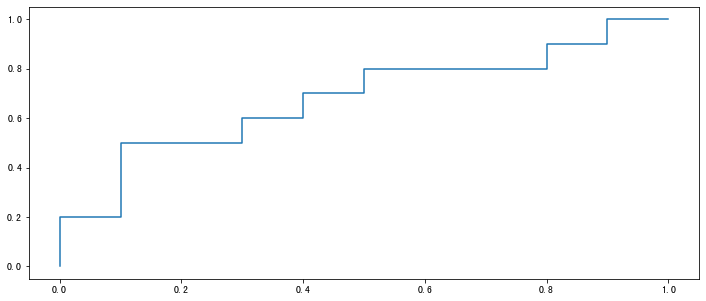

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

ax.plot(fprs, tprs);

In [30]:
def get_ftpr_pairs2(
    y_pred_prob: List[float], 
    y_true: List[int]
    ) -> Tuple[List[int], List[int]]:
    mplus = sum(y_true)
    msub = len(y_true) - mplus
    pairs = [(0, 0)]
    prev = (0, 0)
    length = len(y_pred_prob)
    assert length == len(y_true)
    for i in range(length):
        if y_true[i] == 1:
            pair = (prev[0], prev[1] + 1/mplus)
        else:
            pair = (prev[0] + 1/msub, prev[1])
        pairs.append(pair)
        prev = pair
    pairs.append((1, 1))
    fprs, tprs = [], []
    for pair in pairs:
        fprs.append(pair[0])
        tprs.append(pair[1])
    return fprs, tprs

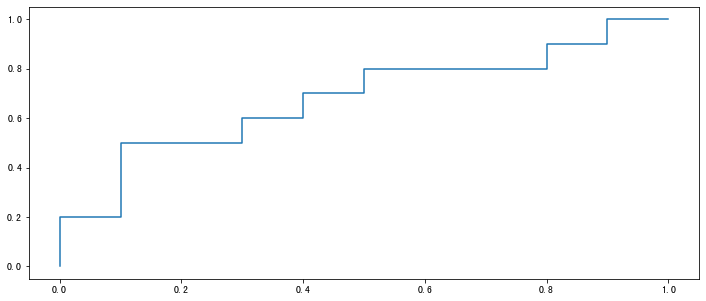

In [31]:
fprs, tprs = get_ftpr_pairs2(y_pred_prob, y_true)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

ax.plot(fprs, tprs);

#### 核心

ROC 与 PR 其实很类似，尤其 TPR 其实就是 Recall，也就是 **PR 曲线的横轴其实就是 ROC 曲线的纵轴**。
即真正的正例中，有多少是被模型预测为正例。

P 是模型的精准率，也就是预测是正例中，真正例的比例；
FPR 是真正的反例中，被预测为正例的比例。

换句话说：

- PR 关注的是真实的正例/预测为正例中（分别对应 Recall 和 Precision），实际是正例的比例
- ROC 关注的是真实的正例/反例中（分别对应 TPR 和 FPR），被预测为正例的比例

#### Sklean 源码

In [2]:
import numpy as np
from sklearn import metrics
y = np.array([1, 1, 2, 2])
pred = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
metrics.auc(fpr, tpr)

0.75

In [3]:
from sklearn.metrics import roc_auc_score
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
roc_auc_score(y_true, y_scores)

0.75

### KS test

In [323]:
from scipy import stats
rvs1 = stats.norm.rvs(size=200, loc=0., scale=1)
rvs2 = stats.norm.rvs(size=300, loc=0.5, scale=1.5)
stats.ks_2samp(rvs1, rvs2)

Ks_2sampResult(statistic=0.265, pvalue=7.126401335710852e-08)

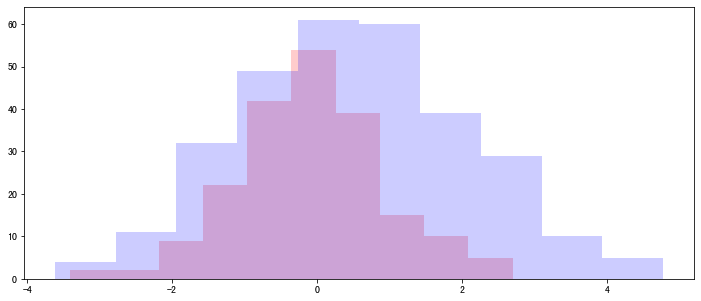

In [364]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))
ax.hist(rvs1, density=False, histtype='stepfilled', alpha=0.2, color='red');
ax.hist(rvs2, density=False, histtype='stepfilled', alpha=0.2, color='blue');

In [33]:
stats.ks_2samp(fprs, tprs)

Ks_2sampResult(statistic=0.2727272727272727, pvalue=0.39373973565829246)

In [41]:
from scipy import stats
import numpy as np

import matplotlib.pyplot as plt
y_pred_prob = [0.9, 0.8, 0.7, 0.6, 0.55, 0.54, 0.53, 0.52, 0.51, 0.505,
               0.4, 0.39, 0.38, 0.37, 0.36, 0.35, 0.34, 0.33, 0.3, 0.1]
y_true = [1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
y_pred = [1] * 10 + [0] * 10

In [36]:
ks = []
for i in range(len(tprs)):
    ks.append(tprs[i] - fprs[i])

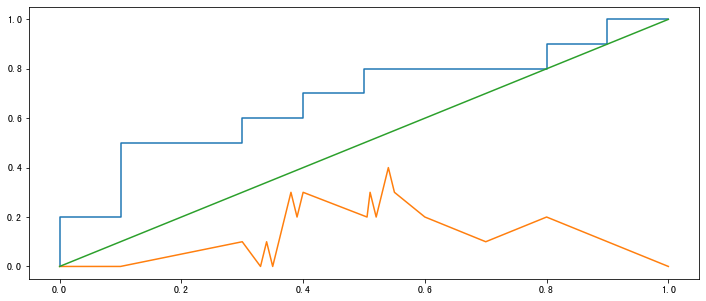

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

x = [1.0] + y_pred_prob + [0.0]

ax.plot(fprs, tprs);
ax.plot(x, ks);
ax.plot(x, x);

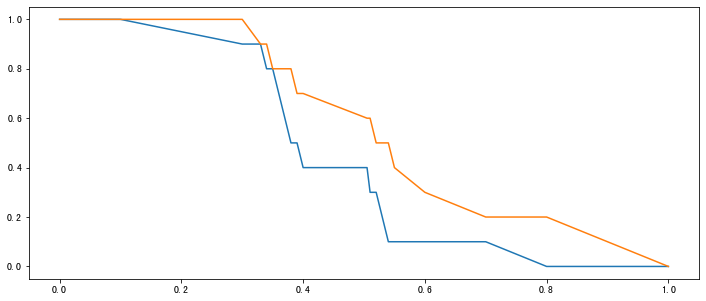

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

x = [1.0] + y_pred_prob + [0.0]

# ax.plot(fprs, tprs);
ax.plot(x, fprs);
ax.plot(x, tprs);

In [55]:
stats.ttest_ind(fprs, tprs)

Ttest_indResult(statistic=-1.6612295549234886, pvalue=0.10411533464755139)

In [53]:
stats.ks_2samp(fprs, tprs)

Ks_2sampResult(statistic=0.2727272727272727, pvalue=0.39373973565829246)